In [53]:
import os
import glob
from copy import deepcopy
from utils.params import dict_update
from dataset.utils.homographic_augmentation import homographic_aug_pipline
from dataset.utils.photometric_augmentation import PhotoAugmentor
from utils.keypoint_op import compute_keypoint_map
from dataset.utils.photometric_augmentation import *
from torchvision import transforms
from torch.utils.data import DataLoader

In [54]:
class SelfDataset(torch.utils.data.Dataset):

    def __init__(self, config, is_train, device='cpu'):

        super(SelfDataset, self).__init__()
        self.device = device
        self.is_train = is_train
        self.resize = tuple(config['resize'])
        self.photo_augmentor = PhotoAugmentor(config['augmentation']['photometric'])
        # load config
        self.config = config
        # get images
        if self.is_train:
            self.samples = self._init_data(config['image_train_path'], config['label_train_path'], config['pairs_train_path'])
        else:
            self.samples = self._init_data(config['image_test_path'], config['label_test_path'], config['pairs_test_path'])


    def _init_data(self, image_path, label_path=None, pair_path=None):
        ##
        if not isinstance(image_path,list):
            image_paths, label_paths, pair_paths = [image_path,], [label_path,], [pair_path,]
        else:
            image_paths, label_paths, pair_paths = image_path, label_path, pair_path

        image_types = ['jpg','jpeg','bmp','png']
        samples = []
        for im_path, lb_path, pair_path in zip(image_paths, label_paths, pair_paths):
            pairs = np.load(os.path.join(pair_path, 'pairs.npy'), allow_pickle=True)
            pairs = pairs.item()
            for key in pairs:
                filename = key.split(".")[0]
                temp_im = os.path.join(im_path, key)
                if lb_path is not None:
                    temp_lb = os.path.join(lb_path, filename+'.npy')
                else:
                    temp_lb = None
                for i in range(len(pairs[key]['pairs'])):
                    pair = pairs[key]['pairs'][i]
                    filename = pair.split(".")[0]
                    covisibility = pairs[key]['covisibility'][i]
                    index = pairs[key]['index'][i]
                    temp_im1 = os.path.join(im_path, pair)
                    if lb_path is not None:
                        temp_lb1 = os.path.join(lb_path, filename+'.npy')
                    else:
                        temp_lb1 = None
                    samples.append({'image':temp_im, 'label':temp_lb, 'image1':temp_im1, 'label1': temp_lb1, 'index': index, 'covisibility': covisibility})
        return samples

    def __len__(self):
        return len(self.samples)


    def __getitem__(self, idx):
        '''load raw data'''
        
        data_path = self.samples[idx]
        
         # load images
        img = cv2.imread(data_path['image'], 0)#Gray image
        img = cv2.resize(img, self.resize[::-1])
        img_tensor = torch.as_tensor(img.copy(), dtype=torch.float, device=self.device)
        img1 = cv2.imread(data_path['image1'], 0)#Gray image
        img1 = cv2.resize(img1, self.resize[::-1])
        img_tensor1 = torch.as_tensor(img1.copy(), dtype=torch.float, device=self.device)

        pts = None if data_path['label'] is None else np.load(data_path['label'])[:, [1,0,2]]
        pts1 = None if data_path['label1'] is None else np.load(data_path['label1'])[:, [1,0,2]]
        pts[:, 0] = pts[:, 0]/1280*self.resize[0]
        pts[:, 1] = pts[:, 1]/1920*self.resize[1]
        pts1[:, 0] = pts1[:, 0]/1280*self.resize[0]
        pts1[:, 1] = pts1[:, 1]/1920*self.resize[1]
        
        kpts_tensor = None if pts is None else torch.as_tensor(pts, device=self.device)
        kpts_tensor1 = None if pts1 is None else torch.as_tensor(pts1, device=self.device)
        
        # compute maps
        kpts_map = None if pts is None else compute_keypoint_map(kpts_tensor, img.shape, device=self.device, id_included=True)
        kpts_map1 = None if pts1 is None else compute_keypoint_map(kpts_tensor1, img1.shape, device=self.device, id_included=True)
        valid_mask = torch.ones(img.shape, device=self.device)
        valid_mask1 = torch.ones(img1.shape, device=self.device)
        pairs = torch.as_tensor(np.array(data_path['covisibility']).astype(np.float32), device=self.device)
        index = torch.as_tensor(np.array(data_path['index']).astype(np.float32), device=self.device)


        data = {    'image':{'raw':{'img': img_tensor,
                                    'kpts': kpts_tensor,
                                    'kpts_map':kpts_map,
                                    'mask': valid_mask},
                            'warp':{'img': None,
                                    'kpts': None,
                                    'kpts_map':None,
                                    'mask': None},
                            'homo': torch.eye(3,device=self.device)},
                    'image1':{'raw':{'img': img_tensor1,
                                    'kpts': kpts_tensor1,
                                    'kpts_map':kpts_map1,
                                    'mask': valid_mask1},
                            'warp':{'img': None,
                                    'kpts': None,
                                    'kpts_map':None,
                                    'mask': None},
                            'homo': torch.eye(3,device=self.device)}, 
                    'index': index,
                    'pairs': pairs      
                }
        
        data['image']['warp'] = deepcopy(data['image']['raw'])
        data['image1']['warp'] = deepcopy(data['image1']['raw'])
        
        if self.is_train:
            photo_enable = self.config['augmentation']['photometric']['train_enable']
            homo_enable = self.config['augmentation']['homographic']['train_enable']
        else:
            photo_enable = self.config['augmentation']['photometric']['test_enable']
            homo_enable = self.config['augmentation']['homographic']['test_enable']

        if homo_enable and data['image']['raw']['kpts'] is not None and data['image1']['raw']['kpts'] is not None:#homographic augmentation
            data_homo = homographic_aug_pipline(data['image']['warp']['img'],
                                                data['image']['warp']['kpts'],
                                                self.config['augmentation']['homographic'],
                                                device=self.device, id_included=True)
            data_homo1 = homographic_aug_pipline(data['image1']['warp']['img'],
                                                data['image1']['warp']['kpts'],
                                                self.config['augmentation']['homographic'],
                                                device=self.device, id_included=True)
            data['image'].update(data_homo)
            data['image1'].update(data_homo1)
            
        if photo_enable:
            photo_img = data['image']['warp']['img'].cpu().numpy().round().astype(np.uint8)
            photo_img = self.photo_augmentor(photo_img)
            data['image']['warp']['img'] = torch.as_tensor(photo_img, dtype=torch.float,device=self.device)
            photo_img1 = data['image1']['warp']['img'].cpu().numpy().round().astype(np.uint8)
            photo_img1 = self.photo_augmentor(photo_img1)
            data['image1']['warp']['img'] = torch.as_tensor(photo_img1, dtype=torch.float,device=self.device)
      
        # normalize
        data['image']['raw']['img'] = data['image']['raw']['img']/255.
        data['image']['warp']['img'] = data['image']['warp']['img']/255.
        data['image1']['raw']['img'] = data['image1']['raw']['img']/255.
        data['image1']['warp']['img'] = data['image1']['warp']['img']/255.
        
        print(data['image']['raw']['kpts_map'])
        return data
    

    def batch_collator(self, samples):
        """
        :param samples:a list, each element is a dict with keys
        like `img`, `img_name`, `kpts`, `kpts_map`,
        `valid_mask`, `homography`...
        img:H*W, kpts:N*2, kpts_map:HW, valid_mask:HW, homography:HW
        :return:
        """
        sub_data={  'raw':{ 'img':      [],
                            'kpts':     [],
                            'kpts_map': [],
                            'mask':     []},
                    'warp':{'img':      [],
                            'kpts':     [],
                            'kpts_map': [],
                            'mask':     []},
                    'homo':             []}
        batch = {'image':deepcopy(sub_data), 'image1':deepcopy(sub_data), 'index': [], 'pairs': []}
        for s in samples:
            batch['index'].append(s['index'])
            batch['pairs'].append(s['pairs'])
            batch['image']['raw']['img'].append(s['image']['raw']['img'].unsqueeze(dim=0))
            batch['image']['raw']['kpts'].append(s['image']['raw']['kpts'])
            batch['image']['raw']['kpts_map'].append(s['image']['raw']['kpts_map'])
            batch['image']['raw']['mask'].append(s['image']['raw']['mask'])
            batch['image']['warp']['img'].append(s['image']['warp']['img'].unsqueeze(dim=0))
            batch['image']['warp']['kpts'].append(s['image']['warp']['kpts'])
            batch['image']['warp']['kpts_map'].append(s['image']['warp']['kpts_map'])
            batch['image']['warp']['mask'].append(s['image']['warp']['mask'])
            batch['image']['homo'].append(s['image']['homo'])
            batch['image1']['raw']['img'].append(s['image1']['raw']['img'].unsqueeze(dim=0))
            batch['image1']['raw']['kpts'].append(s['image1']['raw']['kpts'])
            batch['image1']['raw']['kpts_map'].append(s['image1']['raw']['kpts_map'])
            batch['image1']['raw']['mask'].append(s['image1']['raw']['mask'])
            batch['image1']['warp']['img'].append(s['image1']['warp']['img'].unsqueeze(dim=0))
            batch['image1']['warp']['kpts'].append(s['image1']['warp']['kpts'])
            batch['image1']['warp']['kpts_map'].append(s['image1']['warp']['kpts_map'])
            batch['image1']['warp']['mask'].append(s['image1']['warp']['mask'])
            batch['image1']['homo'].append(s['image1']['homo'])
        batch['index'] = torch.stack(batch['index']) 
        batch['pairs'] = torch.stack(batch['pairs'])
        for k0 in ('image','image1'):
            batch[k0]['homo'] = torch.stack(batch[k0]['homo'])
            for k1 in ('raw','warp'):
                for k2 in sub_data['raw']:
                    batch[k0][k1][k2] = torch.stack(batch[k0][k1][k2])
        return batch

[[4.25043869e+00 1.40442639e+03 1.00000000e+00]
 [6.05427408e+00 1.41141699e+03 2.00000000e+00]
 [8.64255905e+00 1.42166052e+03 3.00000000e+00]
 ...
 [8.93782776e+02 9.99249146e+02 5.00000000e+03]
 [5.52083862e+02 1.19021704e+03 5.00100000e+03]
 [3.19983521e+02 8.95235962e+02 5.00200000e+03]]
240 320
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)
0 {'image': {'raw': {'img': tensor([[[[0.1333, 0.1255, 0.1216,  ..., 0.0471, 0.0510, 0.0471],
          [0.1137, 0.1137, 0.1137,  ..., 0.0471, 0.0510, 0.0392],
          [0.1137, 0.1176, 0.1176,  ..., 0.0549, 0.0510, 0.0549],
          ...,
          [0.0549, 0.0588, 0.0510,  ..., 0.0902, 0.0863, 0.0863],
          [0.0588, 0.0588, 0.0588,  ..., 0.0902, 0.0863, 0.0941],
          [0.0549, 0.0627, 0.0627,  ..., 0.0902, 0.0941, 0.0902]]]]), 'kpts': tensor([[[

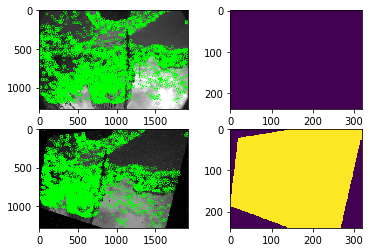

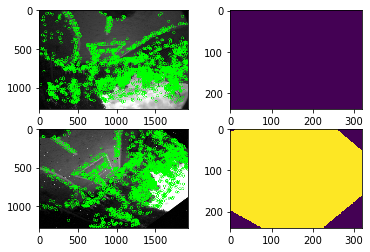

[[5.75795650e+00 1.21934314e+03 1.00000000e+00]
 [1.29266090e+01 1.22851697e+03 2.00000000e+00]
 [1.44729242e+01 1.37843799e+03 3.00000000e+00]
 ...
 [8.92828369e+02 4.02364136e+02 2.65900000e+03]
 [8.93173218e+02 1.65217236e+03 2.66000000e+03]
 [6.42953918e+02 1.35902612e+03 2.66100000e+03]]
240 320
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)
1 {'image': {'raw': {'img': tensor([[[[0.0510, 0.0588, 0.0392,  ..., 0.0275, 0.0314, 0.0157],
          [0.0431, 0.0392, 0.0392,  ..., 0.0431, 0.0353, 0.0314],
          [0.0353, 0.0314, 0.0235,  ..., 0.0431, 0.0314, 0.0235],
          ...,
          [0.0118, 0.0196, 0.0078,  ..., 0.0235, 0.0078, 0.0078],
          [0.0235, 0.0118, 0.0078,  ..., 0.0157, 0.0078, 0.0196],
          [0.0196, 0.0157, 0.0078,  ..., 0.0157, 0.0118, 0.0118]]]]), 'kpts': tensor([[[

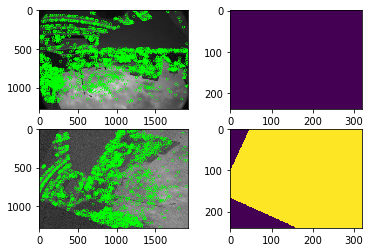

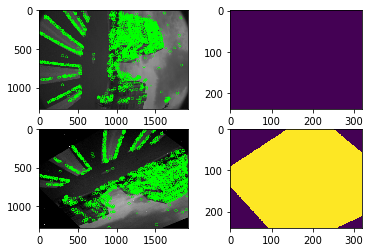

[[9.42336380e-01 1.36275989e+03 1.00000000e+00]
 [8.87706661e+00 1.23415173e+03 2.00000000e+00]
 [9.98517895e+00 1.35608972e+03 3.00000000e+00]
 ...
 [7.74942627e+02 7.46616333e+02 2.89200000e+03]
 [3.52190308e+02 8.20586853e+02 2.89300000e+03]
 [7.70917480e+02 1.43819385e+03 2.89400000e+03]]
240 320
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)
2 {'image': {'raw': {'img': tensor([[[[0.0392, 0.0706, 0.0627,  ..., 0.0314, 0.0392, 0.0235],
          [0.0353, 0.0510, 0.0588,  ..., 0.0353, 0.0314, 0.0235],
          [0.0431, 0.0549, 0.0431,  ..., 0.0275, 0.0353, 0.0314],
          ...,
          [0.0275, 0.0353, 0.0392,  ..., 0.0275, 0.0235, 0.0235],
          [0.0314, 0.0392, 0.0314,  ..., 0.0275, 0.0314, 0.0235],
          [0.0196, 0.0196, 0.0314,  ..., 0.0196, 0.0235, 0.0314]]]]), 'kpts': tensor([[[

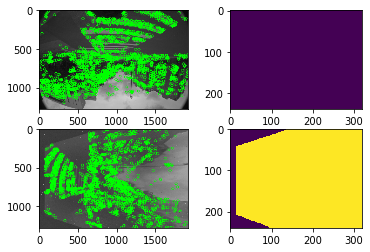

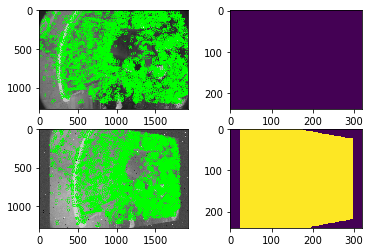

[[1.23700130e+00 1.75538452e+03 1.00000000e+00]
 [3.98027039e+00 4.25673096e+02 2.00000000e+00]
 [3.67539501e+00 1.31917920e+03 3.00000000e+00]
 ...
 [7.97807434e+02 5.54657654e+02 9.74800000e+03]
 [7.97807434e+02 5.54657654e+02 9.74900000e+03]
 [7.63461060e+02 1.32716943e+03 9.75000000e+03]]
240 320
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)
3 {'image': {'raw': {'img': tensor([[[[0.0392, 0.0706, 0.0549,  ..., 0.1137, 0.1059, 0.1020],
          [0.0588, 0.0588, 0.0549,  ..., 0.1020, 0.1098, 0.1098],
          [0.0667, 0.0627, 0.0706,  ..., 0.1137, 0.1137, 0.0941],
          ...,
          [0.0549, 0.0471, 0.0549,  ..., 0.0549, 0.0510, 0.0627],
          [0.0549, 0.0549, 0.0549,  ..., 0.0588, 0.0549, 0.0510],
          [0.0549, 0.0510, 0.0510,  ..., 0.0510, 0.0510, 0.0431]]]]), 'kpts': tensor([[[

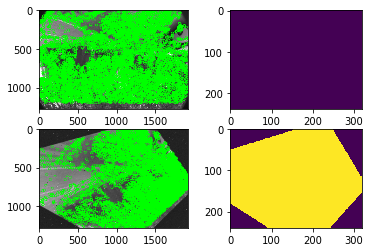

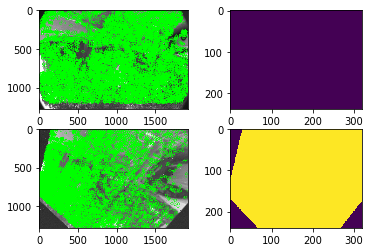

[[1.15794051e+00 1.17532886e+03 1.00000000e+00]
 [2.20540357e+00 1.48626697e+03 2.00000000e+00]
 [2.56530094e+00 1.50396301e+03 3.00000000e+00]
 ...
 [9.02263428e+02 9.26750122e+02 6.33000000e+03]
 [1.62451935e+02 1.12454260e+03 6.33100000e+03]
 [2.88974884e+02 1.67845276e+03 6.33200000e+03]]
240 320
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)
4 {'image': {'raw': {'img': tensor([[[[0.1020, 0.1098, 0.1216,  ..., 0.1059, 0.0980, 0.1020],
          [0.1059, 0.1059, 0.1176,  ..., 0.1020, 0.1020, 0.1020],
          [0.1020, 0.1059, 0.1137,  ..., 0.1098, 0.1059, 0.1059],
          ...,
          [0.1333, 0.1373, 0.1412,  ..., 0.1137, 0.1098, 0.1098],
          [0.1373, 0.1333, 0.1333,  ..., 0.1020, 0.1059, 0.1059],
          [0.1294, 0.1373, 0.1333,  ..., 0.1098, 0.1098, 0.1059]]]]), 'kpts': tensor([[[

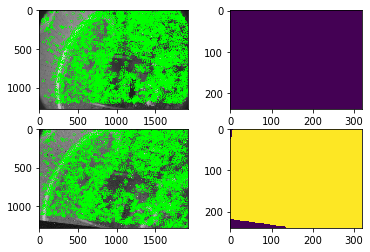

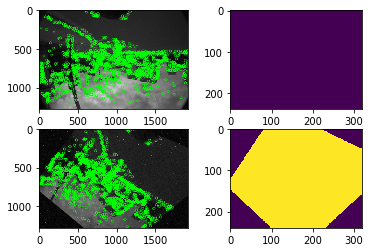

[[3.26862121e+00 5.47671997e+02 1.00000000e+00]
 [5.33629465e+00 2.10986252e+02 2.00000000e+00]
 [5.20860720e+00 7.47379761e+02 3.00000000e+00]
 ...
 [3.97837219e+02 1.67206470e+03 2.52100000e+03]
 [4.42825745e+02 9.17801514e+02 2.52200000e+03]
 [5.53897095e+02 4.87101746e+02 2.52300000e+03]]
240 320
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)
5 {'image': {'raw': {'img': tensor([[[[0.1176, 0.1137, 0.1216,  ..., 0.1059, 0.1059, 0.1098],
          [0.1098, 0.1059, 0.1176,  ..., 0.1059, 0.1020, 0.1059],
          [0.1176, 0.1137, 0.1137,  ..., 0.1059, 0.1059, 0.1137],
          ...,
          [0.1412, 0.1412, 0.1490,  ..., 0.1137, 0.1137, 0.1137],
          [0.1451, 0.1451, 0.1490,  ..., 0.1098, 0.1137, 0.1059],
          [0.1412, 0.1451, 0.1451,  ..., 0.1098, 0.1098, 0.1137]]]]), 'kpts': tensor([[[

In [55]:
if __name__=='__main__':
    import yaml
    import matplotlib.pyplot as plt
    from dataset.utils.photometric_augmentation import *
    with open('/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/config/superpoint_train.yaml','r') as fin:
        config = yaml.safe_load(fin)

    selfdata = SelfDataset(config['data'],True)
    cdataloader = DataLoader(selfdata,collate_fn=selfdata.batch_collator,batch_size=1,shuffle=True)

    for i,d in enumerate(cdataloader):
        print(i,d)
        if i>=5:
            break
        img = (d['image']['raw']['img']*255).cpu().numpy().squeeze().astype(np.int).astype(np.uint8)
        img_warp = (d['image']['warp']['img']*255).cpu().numpy().squeeze().astype(np.int).astype(np.uint8)
        img = cv2.merge([img, img, img])
        img_warp = cv2.merge([img_warp, img_warp, img_warp])
        kpts = np.where(d['image']['raw']['kpts_map'].squeeze().cpu().numpy())
        kpts = np.vstack(kpts).T
        kpts = np.round(kpts).astype(np.int)
        for kp in kpts:
            cv2.circle(img, (kp[1], kp[0]), radius=3, color=(0,255,0))
            
            
        kpts = np.where(d['image']['warp']['kpts_map'].squeeze().cpu().numpy())
        kpts = np.vstack(kpts).T
        kpts = np.round(kpts).astype(np.int)
        for kp in kpts:
            cv2.circle(img_warp, (kp[1], kp[0]), radius=3, color=(0,255,0))

        mask = d['image']['raw']['mask'].cpu().numpy().squeeze().astype(np.int).astype(np.uint8)*255
        warp_mask = d['image']['warp']['mask'].cpu().numpy().squeeze().astype(np.int).astype(np.uint8)*255

        img = cv2.resize(img, (1920,1280))
        img_warp = cv2.resize(img_warp,(1920,1280))

        plt.subplot(2,2,1)
        plt.imshow(img)
        plt.subplot(2,2,2)
        plt.imshow(mask)
        plt.subplot(2,2,3)
        plt.imshow(img_warp)
        plt.subplot(2,2,4)
        plt.imshow(warp_mask)
        plt.show()
        
        img = (d['image1']['raw']['img']*255).cpu().numpy().squeeze().astype(np.int).astype(np.uint8)
        img_warp = (d['image1']['warp']['img']*255).cpu().numpy().squeeze().astype(np.int).astype(np.uint8)
        img = cv2.merge([img, img, img])
        img_warp = cv2.merge([img_warp, img_warp, img_warp])
        
        kpts = np.where(d['image1']['raw']['kpts_map'].squeeze().cpu().numpy())
        kpts = np.vstack(kpts).T
        kpts = np.round(kpts).astype(np.int)
        for kp in kpts:
            cv2.circle(img, (kp[1], kp[0]), radius=3, color=(0,255,0))
            
        kpts = np.where(d['image1']['warp']['kpts_map'].squeeze().cpu().numpy())
        kpts = np.vstack(kpts).T
        kpts = np.round(kpts).astype(np.int)
        for kp in kpts:
            cv2.circle(img_warp, (kp[1], kp[0]), radius=3, color=(0,255,0))

        mask = d['image1']['raw']['mask'].cpu().numpy().squeeze().astype(np.int).astype(np.uint8)*255
        warp_mask = d['image1']['warp']['mask'].cpu().numpy().squeeze().astype(np.int).astype(np.uint8)*255

        img = cv2.resize(img, (1920,1280))
        img_warp = cv2.resize(img_warp,(1920,1280))

        plt.subplot(2,2,1)
        plt.imshow(img)
        plt.subplot(2,2,2)
        plt.imshow(mask)
        plt.subplot(2,2,3)
        plt.imshow(img_warp)
        plt.subplot(2,2,4)
        plt.imshow(warp_mask)
        plt.show()
        
    print('Done')

In [ ]:
# 1003482999.npy
a = np.load('/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/data/self/keypoints/275492960.npy').astype('float32')
a

In [ ]:
pairs = np.load(os.path.join('/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/data/self/pairs.npy'), allow_pickle=True)
pairs = pairs.item()
pairs['1003482999.png']

In [ ]:
for key in pairs['1003482999.png']:
    print(key)

In [22]:
class COCODataset(torch.utils.data.Dataset):

    def __init__(self, config, is_train, device='cpu'):

        super(COCODataset, self).__init__()
        self.device = device
        self.is_train = is_train
        self.resize = tuple(config['resize'])
        self.photo_augmentor = PhotoAugmentor(config['augmentation']['photometric'])
        # load config
        self.config = config #dict_update(getattr(self, 'default_config', {}), config)
        # get images
        if self.is_train:
            self.samples = self._init_data(config['image_train_path'], config['label_train_path'])
        else:
            self.samples = self._init_data(config['image_test_path'], config['label_test_path'])


    def _init_data(self, image_path, label_path=None):
        ##
        if not isinstance(image_path,list):
            image_paths, label_paths = [image_path,], [label_path,]
        else:
            image_paths, label_paths = image_path, label_path

        image_types = ['jpg','jpeg','bmp','png']
        samples = []
        for im_path, lb_path in zip(image_paths, label_paths):
            for it in image_types:
                temp_im = glob.glob(os.path.join(im_path, '*.{}'.format(it)))
                if lb_path is not None:
                    temp_lb = [os.path.join(lb_path, os.path.basename(imp)+'.npy') for imp in temp_im]
                else:
                    temp_lb = [None,]*len(temp_im)
                temp = [{'image':imp, 'label':lb} for imp, lb in zip(temp_im, temp_lb)]
                samples += temp
        ##
        return samples

    def __len__(self):
        return len(self.samples)


    def __getitem__(self, idx):
        '''load raw data'''
        data_path = self.samples[idx]#raw image path of processed image and point path
        img = cv2.imread(data_path['image'], 0)#Gray image
        img = cv2.resize(img, self.resize[::-1])
        pts = None if data_path['label'] is None else np.load(data_path['label'])#N*2,yx
        pts = pts.astype(np.float32)

        # init data dict
        img_tensor = torch.as_tensor(img.copy(), dtype=torch.float, device=self.device)
        kpts_tensor = None if pts is None else torch.as_tensor(pts, device=self.device)
        kpts_map = None if pts is None else compute_keypoint_map(kpts_tensor, img.shape, device=self.device)
        valid_mask = torch.ones(img.shape, device=self.device)

        data = {'raw':{'img': img_tensor,
                       'kpts': kpts_tensor,
                       'kpts_map':kpts_map,
                       'mask':valid_mask},
                'warp':None,
                'homography':torch.eye(3,device=self.device)}
        data['warp'] = deepcopy(data['raw'])

        ##
        if self.is_train:
            photo_enable = self.config['augmentation']['photometric']['train_enable']
            homo_enable = self.config['augmentation']['homographic']['train_enable']
        else:
            photo_enable = self.config['augmentation']['photometric']['test_enable']
            homo_enable = self.config['augmentation']['homographic']['test_enable']


        if homo_enable and data['raw']['kpts'] is not None:#homographic augmentation
            # return dict{warp:{img:[H,W], point:[N,2], valid_mask:[H,W], homography: [3,3]; tensors}}
            data_homo = homographic_aug_pipline(data['warp']['img'],
                                                data['warp']['kpts'],
                                                self.config['augmentation']['homographic'],
                                                device=self.device)
            data.update(data_homo)

        if photo_enable:
            photo_img = data['warp']['img'].cpu().numpy().round().astype(np.uint8)
            photo_img = self.photo_augmentor(photo_img)
            data['warp']['img'] = torch.as_tensor(photo_img, dtype=torch.float,device=self.device)

        ##normalize
        data['raw']['img'] = data['raw']['img']/255.
        data['warp']['img'] = data['warp']['img']/255.
        print("raw", data['raw']['kpts'])
        print("warp", data['warp']['kpts'])
        return data#img:HW, kpts:N2, kpts_map:HW, valid_mask:HW, homography:HW

    def batch_collator(self, samples):
        """
        :param samples:a list, each element is a dict with keys
        like `img`, `img_name`, `kpts`, `kpts_map`,
        `valid_mask`, `homography`...
        img:H*W, kpts:N*2, kpts_map:HW, valid_mask:HW, homography:HW
        :return:
        """
        sub_data = {'img': [], 'kpts_map': [],'mask': []}#remove kpts
        batch = {'raw':sub_data, 'warp':deepcopy(sub_data), 'homography': []}
        for s in samples:
            batch['homography'].append(s['homography'])
            #batch['img_name'].append(s['img_name'])
            for k in sub_data:
                if k=='img':
                    batch['raw'][k].append(s['raw'][k].unsqueeze(dim=0))
                    if 'warp' in s:
                        batch['warp'][k].append(s['warp'][k].unsqueeze(dim=0))
                else:
                    batch['raw'][k].append(s['raw'][k])
                    if 'warp' in s:
                        batch['warp'][k].append(s['warp'][k])
        ##
        batch['homography'] = torch.stack(batch['homography'])
        for k0 in ('raw','warp'):
            for k1 in sub_data:#`img`, `img_name`, `kpts`, `kpts_map`...
                if k1=='kpts' or k1=='img_name':
                    continue
                batch[k0][k1] = torch.stack(batch[k0][k1])

        return batch

raw tensor([[  5., 154.],
        [  6., 141.],
        [  9., 130.],
        [  9., 152.],
        [ 11., 149.],
        [ 12., 108.],
        [ 12., 112.],
        [ 12., 154.],
        [ 12., 228.],
        [ 14., 119.],
        [ 17.,  95.],
        [ 18., 116.],
        [ 18., 227.],
        [ 19., 123.],
        [ 20., 129.],
        [ 20., 252.],
        [ 21., 200.],
        [ 22., 148.],
        [ 23.,  95.],
        [ 23., 238.],
        [ 23., 259.],
        [ 24., 222.],
        [ 25.,  92.],
        [ 25., 140.],
        [ 25., 163.],
        [ 26., 136.],
        [ 27.,  89.],
        [ 28., 267.],
        [ 29., 163.],
        [ 29., 179.],
        [ 31., 312.],
        [ 32., 160.],
        [ 33., 228.],
        [ 35., 185.],
        [ 36., 170.],
        [ 36., 223.],
        [ 37., 130.],
        [ 37., 176.],
        [ 38., 315.],
        [ 39., 205.],
        [ 41., 310.],
        [ 42., 232.],
        [ 43., 176.],
        [ 44., 237.],
        [ 45.,  79.],
      

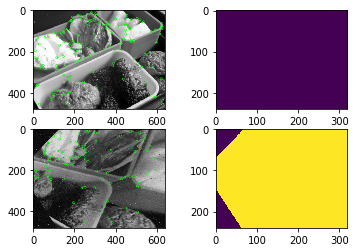

raw tensor([[  3., 110.],
        [ 11., 130.],
        [ 13., 288.],
        [ 15., 285.],
        [ 16., 101.],
        [ 22., 122.],
        [ 23.,   6.],
        [ 24., 164.],
        [ 28.,  99.],
        [ 28., 288.],
        [ 29., 141.],
        [ 31.,  20.],
        [ 33., 161.],
        [ 33., 288.],
        [ 35.,  20.],
        [ 35., 155.],
        [ 36.,  99.],
        [ 39., 141.],
        [ 41.,  76.],
        [ 42.,  50.],
        [ 42., 193.],
        [ 43., 155.],
        [ 43., 189.],
        [ 44., 133.],
        [ 47., 275.],
        [ 48., 270.],
        [ 50.,  98.],
        [ 50., 155.],
        [ 51., 220.],
        [ 52., 188.],
        [ 53., 194.],
        [ 55.,  19.],
        [ 55., 197.],
        [ 55., 301.],
        [ 56., 127.],
        [ 56., 131.],
        [ 56., 178.],
        [ 60.,  49.],
        [ 61., 197.],
        [ 62., 220.],
        [ 65., 212.],
        [ 65., 272.],
        [ 66., 301.],
        [ 68.,  75.],
        [ 68., 236.],
      

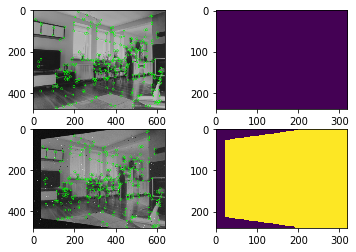

Done


In [23]:
if __name__=='__main__':
    import yaml
    import matplotlib.pyplot as plt
    from dataset.utils.photometric_augmentation import *
    with open('/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/config/superpoint_train.yaml','r') as fin:
        config = yaml.safe_load(fin)


    coco = COCODataset(config['data'],False)
    cdataloader = DataLoader(coco,collate_fn=coco.batch_collator,batch_size=1,shuffle=True)

    for i,d in enumerate(cdataloader):
        if i>=5:
            break
        
        img = (d['raw']['img']*255).cpu().numpy().squeeze().astype(np.int).astype(np.uint8)
        img_warp = (d['warp']['img']*255).cpu().numpy().squeeze().astype(np.int).astype(np.uint8)
        img = cv2.merge([img, img, img])
        img_warp = cv2.merge([img_warp, img_warp, img_warp])
        ##
        kpts = np.where(d['raw']['kpts_map'].squeeze().cpu().numpy())
        kpts = np.vstack(kpts).T
        kpts = np.round(kpts).astype(np.int)
        for kp in kpts:
            cv2.circle(img, (kp[1], kp[0]), radius=3, color=(0,255,0))
        kpts = np.where(d['warp']['kpts_map'].squeeze().cpu().numpy())
        kpts = np.vstack(kpts).T
        kpts = np.round(kpts).astype(np.int)
        for kp in kpts:
            cv2.circle(img_warp, (kp[1], kp[0]), radius=3, color=(0,255,0))

        mask = d['raw']['mask'].cpu().numpy().squeeze().astype(np.int).astype(np.uint8)*255
        warp_mask = d['warp']['mask'].cpu().numpy().squeeze().astype(np.int).astype(np.uint8)*255

        img = cv2.resize(img, (640,480))
        img_warp = cv2.resize(img_warp,(640,480))

        plt.subplot(2,2,1)
        plt.imshow(img)
        plt.subplot(2,2,2)
        plt.imshow(mask)
        plt.subplot(2,2,3)
        plt.imshow(img_warp)
        plt.subplot(2,2,4)
        plt.imshow(warp_mask)
        plt.show()

    print('Done')